In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 

from sklearn.preprocessing import normalize 


In [181]:
emails_dfs=pd.read_csv('./emails.csv')
emails_df=emails_dfs.head(2000)


# Transformation des données en colonnes

In [182]:
def parse_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['date','x-from', 'x-to','subject']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [183]:
def parse_into_emails(messages):
    emails = [parse_message(message) for message in messages]
    return {
        'date':[email['date'] for email in emails],
        'sender' : [email['x-from'] for email in emails],
        'receiver': [email['x-to'] for email in emails], 
        'subject':[email['subject'] for email in emails],
        'body': [email['body'] for email in emails]
        
        
    }


In [184]:
email_df = pd.DataFrame(parse_into_emails(emails_df.message))

In [8]:
email_df

,date,sender,receiver,subject,body
0,"Mon, 14 May 2001 16",Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,Here is our forecast
1,"Fri, 4 May 2001 13",Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Re,Traveling to have a business meeting takes the...
2,"Wed, 18 Oct 2000 03",Phillip K Allen,Leah Van Arsdall,Re,test successful. way to go!!!
3,"Mon, 23 Oct 2000 06",Phillip K Allen,Randall L Gay,,"Randy,Can you send me a schedule of the salary..."
4,"Thu, 31 Aug 2000 05",Phillip K Allen,Greg Piper,Re,
5,"Thu, 31 Aug 2000 04",Phillip K Allen,Greg Piper,Re,"Greg,How about either next Tuesday or Thursday..."
6,"Tue, 22 Aug 2000 07",Phillip K Allen,"david.l.johnson@enron.com, John Shafer",,Phillip Allen (pallen@enron.com)Mike Grigsby (...
7,"Fri, 14 Jul 2000 06",Phillip K Allen,Joyce Teixeira,Re,
8,"Tue, 17 Oct 2000 02",Phillip K Allen,Mark Scott,Re,I don't think these are required by the ISP2. ...
9,"Mon, 16 Oct 2000 06",Phillip K Allen,zimam@enron.com,FW,---------------------- Forwarded by Phillip K ...


# Eleminer les lignes pour lesquelles 'body' est vide

In [185]:
# Drop emails with empty body, to or from_ columns. 
email_df.drop(email_df.query("body == ''").index, inplace=True)

# Extraction des lemmes et suppression des stop words

In [187]:
import nltk
import gensim

In [188]:
#transformation des lignes en mots
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data_text['body']))


In [189]:
#suppression des stopwords
def remove_stopwords(texts):
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.append('Forwarded')
    stop_words.append('forwarded')
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [ ]:
#lemmatization

In [190]:
import spacy
from spacy import displacy


In [191]:
import nltk
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [192]:
def lemmatization(text):
    for sent in data_words:
        for i in sent :
            data_lemmatized = ' '.join([lemmatizer.lemmatize(i) ])
    return lemmatized_output

In [193]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser 

In [216]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Do lemmatization
data_lemmatized = lemmatization(data_words_nostops)
data_lemm=data_lemmatized.split(' ')



# LDA

In [219]:
# Create Corpus
texts =[data_lemm]
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [197]:
#Creation du modele LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [198]:
#Affichage des topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.038*"sheet" + 0.037*"mike" + 0.036*"tw" + 0.036*"pg" + 0.036*"need" + 0.036*"would" + 0.036*"forecast" + 0.036*"hou" + 0.036*"also" + 0.036*"grigsbylet"
Topic: 1 
Words: 0.036*"thedesk" + 0.036*"tie" + 0.036*"rate" + 0.036*"sheet" + 0.036*"socal" + 0.036*"talk" + 0.036*"pg" + 0.036*"well" + 0.036*"tw" + 0.036*"need"
Topic: 2 
Words: 0.036*"thedesk" + 0.036*"tie" + 0.036*"rate" + 0.036*"sheet" + 0.036*"socal" + 0.036*"talk" + 0.036*"pg" + 0.036*"well" + 0.036*"tw" + 0.036*"need"
Topic: 3 
Words: 0.036*"thedesk" + 0.036*"tie" + 0.036*"rate" + 0.036*"sheet" + 0.036*"socal" + 0.036*"talk" + 0.036*"pg" + 0.036*"well" + 0.036*"tw" + 0.036*"need"
Topic: 4 
Words: 0.036*"thedesk" + 0.036*"tie" + 0.036*"rate" + 0.036*"sheet" + 0.036*"socal" + 0.036*"talk" + 0.036*"pg" + 0.036*"well" + 0.036*"tw" + 0.036*"need"
Topic: 5 
Words: 0.039*"sheet" + 0.036*"mike" + 0.036*"allen" + 0.036*"daily" + 0.036*"tie" + 0.036*"pg" + 0.036*"need" + 0.036*"grigsbylet" + 0.036*"tw" + 0.036*"onpip

# Kmeans

In [205]:
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(email_df.body)

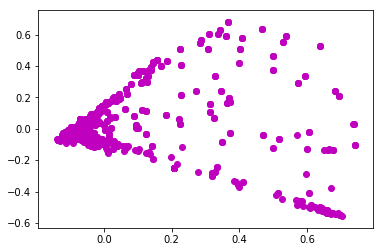

In [209]:
X_dense = X.todense()
coords = PCA(n_components=20).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [210]:
#top key words in the email exemple email 1
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df


In [211]:
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)
features = vect.get_feature_names()
print (top_feats_in_doc(X, features, 1, 10))

     features     score
0    meetings  0.410615
1        trip  0.346908
2    business  0.301024
3         ski  0.269165
4       takes  0.205308
5         try  0.141450
6         jet  0.139970
7        boat  0.134582
8   stimulate  0.134582
9  suggestion  0.134582


In [212]:
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)


In [213]:
c = clf.cluster_centers_

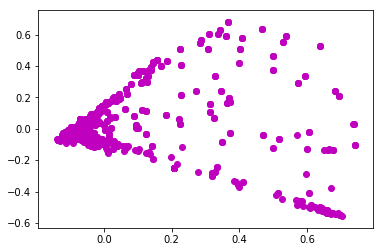

In [214]:
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

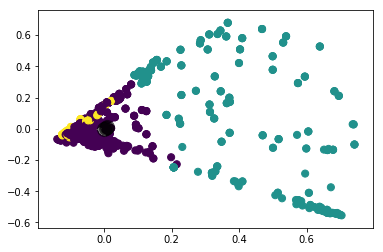

In [215]:
plt.scatter(coords[:, 0], coords[:, 1], c=labels, s=50, cmap='viridis')

centers = clf.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);